In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from datetime import datetime, timedelta
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error 

from tqdm import tqdm_notebook
import gc

# 1. 데이터 Load

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

In [3]:
train.shape, test.shape, gender_submission.shape

((891, 12), (418, 11), (418, 2))

In [4]:
train.head(3)
test.head(3)
gender_submission.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [5]:
df = pd.concat((train, test)) 
df.shape

(1309, 12)

# 2.  EDA & 전처리 -> Feature Engineering

## 공통 함수

In [6]:
def value_counts(df, cols):
    for col in cols:
        print(col)
        print(df[col].value_counts(),'\n')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


 - categorical: Pclass, Sex, Embarked     
 - String: Name, Ticket   
 - ??: Cabin        

In [8]:
## id 중복 확인
train[train.duplicated(['PassengerId'])]
test[test.duplicated(['PassengerId'])]
# 중복 없음

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [9]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Kink-Heilmann, Miss. Luise Gretchen",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


- Missing Value: Age, Cabin, Embarked
- Categorical: Sex(2), Embarked(3)
- Name 중복 없음 

### Missing Value

In [10]:
df.isnull().sum()    # Age, Fare, Cabin, Embarked
train.isnull().sum() # Age      , Cabin, Embarked
test.isnull().sum()  # Age, Fare, Cabin

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### Missing Value: Fare - only test(1건)

In [11]:
test[test.Fare.isna()].index
test[test.Fare.isna()]

Int64Index([152], dtype='int64')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


- Fare 가 null 인 컬럼<br>
Pclass: 3<br>
Ticket: 3701<br>
Embarked: S<br>

In [12]:
# 동일 조건을 가진 다른 컬럼의 Fare 검색
cond = (df.Pclass==3) & (df.Ticket.str.contains('3701')) & (df.Embarked == 'S')
df[cond]
# 동일한 값을 가지는것으로 파악 Fare -> Update

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
254,255,0.0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.0,0,2,370129,20.2125,NaN,S
424,425,0.0,3,"Rosblom, Mr. Viktor Richard",male,18.0,1,1,370129,20.2125,NaN,S
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S
284,1176,NaN,3,"Rosblom, Miss. Salli Helena",female,2.0,1,1,370129,20.2125,NaN,S


In [13]:
# Fare: 20.2125
# Ticket: 3701 -> 370129 (동일한 조건의 오기재된 정보로 보여 업데이트)
test.loc[152,'Fare'] = 20.2125
test.loc[152,'Ticket'] = '370129'

#### Missing Value: Embarked - only train(2건)

In [14]:
train[train.Embarked.isna()].index
train[train.Embarked.isna()]

Int64Index([61, 829], dtype='int64')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [15]:
# null값을 가지는 다른 공통 정보로 검색 
df[df.Cabin.str.contains('B2')==True]
# Cabin BX 로 시작하는 데이터는 Embarked = 'S'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.00,B28,NaN
540,541,1.0,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.00,B22,S
690,691,1.0,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.00,B20,S
745,746,0.0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
781,782,1.0,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.00,B20,S
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.00,B28,NaN
305,1197,NaN,1,"Crosby, Mrs. Edward Gifford (Catherine Elizabe...",female,64.0,1,1,112901,26.55,B26,S
390,1282,NaN,1,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.50,B24,S


In [16]:
train.loc[train[train.Embarked.isna()].index, 'Embarked'] = 'S'
train.loc[[61, 829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


#### Missing Value: Age - train test (263건)

In [17]:
df[df.Age.isna()].index
df[df.Age.isna()]
# Name 에서 정보 추출 

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            365, 366, 380, 382, 384, 408, 410, 413, 416, 417],
           dtype='int64', length=263)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
410,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [18]:
# Initial: Title 추출 XXXX.
train['Initial'] = train.Name.str.extract('([A-Za-z]+)\.') 
test['Initial'] = test.Name.str.extract('([A-Za-z]+)\.') 

In [19]:
# Name2: 성 추출 .XXXX
train['Name2'] = train.Name.str.extract('(([A-Za-z])+(?=,))')[0]
test['Name2'] = test.Name.str.extract('(([A-Za-z])+(?=,))')[0]

In [20]:
# Family: 가족 수 = 형제자매 + 부모/자녀 + 나자신 
train['Family'] = (train['SibSp'] + train['Parch'] + 1).astype('int')
test['Family'] = (test['SibSp'] + test['Parch'] + 1).astype('int')

In [21]:
# Age_NA: 나이가 null 인건은 -1, null 이 아닌 건은 0으로 표현하는 컬럼을 추가 
train['Age_NA'] = 0
test['Age_NA'] = 0

train_idx = train[train['Age'].isna()].index
test_idx = test[test['Age'].isna()].index

train.loc[train_idx, 'Age_NA'] = -1
test.loc[test_idx, 'Age_NA'] = -1

In [22]:
# Initial 중 Age_NA 값이 0이 아닌 경우 null 이 존재하는 Initial 로 판단

train.groupby(by='Initial').agg({'Initial':['count'],'Age':['min','max', 'mean'], 'Age_NA':['sum']})
# Initial(null건수/총건수): Dr(1/7), Master(4/40), Miss(36/182), Mr(119/517), Mrs(17/125)

test.groupby(by='Initial').agg({'Initial':['count'],'Age':['min','max', 'mean'], 'Age_NA':['sum']})
# Initial(null건수/총건수): Master(4/21), Miss(14/78), Mr(240/517), Mrs(10/72), Ms(1/1)

df = pd.concat((train, test)) 
df.groupby(by='Initial').agg({'Initial':['count'],'Age':['min','max', 'mean'], 'Age_NA':['sum']})

Initial    Age                  Age_NA
           count    min   max       mean    sum
Initial                                        
Capt           1  70.00  70.0  70.000000      0
Col            2  56.00  60.0  58.000000      0
Countess       1  33.00  33.0  33.000000      0
Don            1  40.00  40.0  40.000000      0
Dr             7  23.00  54.0  42.000000     -1
Jonkheer       1  38.00  38.0  38.000000      0
Lady           1  48.00  48.0  48.000000      0
Major          2  45.00  52.0  48.500000      0
Master        40   0.42  12.0   4.574167     -4
Miss         182   0.75  63.0  21.773973    -36
Mlle           2  24.00  24.0  24.000000      0
Mme            1  24.00  24.0  24.000000      0
Mr           517  11.00  80.0  32.368090   -119
Mrs          125  14.00  63.0  35.898148    -17
Ms             1  28.00  28.0  28.000000      0
Rev            6  27.00  57.0  43.166667      0
Sir            1  49.00  49.0  49.000000      0

Initial    Age                  Age_NA
          count    min   max       mean    sum
Initial                                       
Col           2  47.00  53.0  50.000000      0
Dona          1  39.00  39.0  39.000000      0
Dr            1  53.00  53.0  53.000000      0
Master       21   0.33  14.5   7.406471     -4
Miss         78   0.17  45.0  21.774844    -14
Mr          240  14.00  67.0  32.000000    -57
Mrs          72  16.00  76.0  38.903226    -10
Ms            1    NaN   NaN        NaN     -1
Rev           2  30.00  41.0  35.500000      0

Initial    Age                  Age_NA
           count    min   max       mean    sum
Initial                                        
Capt           1  70.00  70.0  70.000000      0
Col            4  47.00  60.0  54.000000      0
Countess       1  33.00  33.0  33.000000      0
Don            1  40.00  40.0  40.000000      0
Dona           1  39.00  39.0  39.000000      0
Dr             8  23.00  54.0  43.571429     -1
Jonkheer       1  38.00  38.0  38.000000      0
Lady           1  48.00  48.0  48.000000      0
Major          2  45.00  52.0  48.500000      0
Master        61   0.33  14.5   5.482642     -8
Miss         260   0.17  63.0  21.774238    -50
Mlle           2  24.00  24.0  24.000000      0
Mme            1  24.00  24.0  24.000000      0
Mr           757  11.00  80.0  32.252151   -176
Mrs          197  14.00  76.0  36.994118    -27
Ms             2  28.00  28.0  28.000000     -1
Rev            8  27.00  57.0  41.250000      0
Sir            1  49.00  49.0  49.000000      0

In [23]:
# 1. Ms(1건)
## train 에 없던 test Ms 1건이 존재하며 Null 값임 
# train 데이터의 Ms(1건)을 참고로 test Ms 를 28.0세로 세팅
df[df.Initial == 'Ms']
test.loc[88, 'Age'] = 28.0
test.loc[test.Initial == 'Ms', 'Age']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Name2,Family,Age_NA
443,444,1.0,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.00,NaN,S,Ms,Reynaldo,1,0
88,980,NaN,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.75,NaN,Q,Ms,Donoghue,1,-1


88    28.0
Name: Age, dtype: float64

In [24]:
# 2. Dr(1건)
# 8건 중에 1건 null
# Age: 23.00~54.0, 평균: 43.571429
df[df.Initial == 'Dr']

# 1건의 세부 정보와 동일한 조건의(Pclass == 1 & Sex=='male') 평균으로 업데이트
train.loc[766, 'Age'] = df[(df.Initial == 'Dr') & (df.Pclass==1) & (df.Sex=='male')]['Age'].mean() # 44.75

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Name2,Family,Age_NA
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Dr,Minahan,3,0
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Dr,Moraweck,1,0
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Dr,Pain,1,0
632,633,1.0,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Dr,Maeglin,1,0
660,661,1.0,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Dr,Frauenthal,3,0
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Dr,Brewe,1,-1
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Dr,Leader,1,0
293,1185,NaN,1,"Dodge, Dr. Washington",male,53.0,1,1,33638,81.8583,A34,S,Dr,Dodge,3,0


In [25]:
# 3. Master ~ 14세 이하(생존률 높음 주의!)
# 61건 중에 8건 NULL
# Age: 0.33~14.5 평균: 5.482642
df[((df.Initial == 'Master') & (df.Age.isna()))]

# null건의 세부 정보와 동일한 조건의(Pclass == 3 & Sex == 'male') 평균으로 업데이트
df[((df.Initial == 'Master') & (df.Pclass==3) & (df.Sex=='male'))]['Age'].mean() # 6.09

train.loc[((train.Initial == 'Master') & (train.Age.isna())), 'Age'] = 6.09
test.loc[((test.Initial == 'Master') & (test.Age.isna())), 'Age'] = 6.09

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Name2,Family,Age_NA
65,66,1.0,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C,Master,Moubarek,3,-1
159,160,0.0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S,Master,Sage,11,-1
176,177,0.0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S,Master,Lefebre,5,-1
709,710,1.0,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,Master,Moubarek,3,-1
244,1136,NaN,3,"Johnston, Master. William Arthur Willie""""",male,NaN,1,2,W./C. 6607,23.4500,NaN,S,Master,Johnston,4,-1
339,1231,NaN,3,"Betros, Master. Seman",male,NaN,0,0,2622,7.2292,NaN,C,Master,Betros,1,-1
344,1236,NaN,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S,Master,Billiard,3,-1
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Master,Peter,3,-1


6.090000000000001

In [26]:
# 4. Mrs (Sex == 'female' )
# 197건 중에 27건 NULL
# Age: 14.00~76.0 평균: 36.994118
df[((df.Initial == 'Mrs') & (df.Age.isna()))].head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Name2,Family,Age_NA
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs,Masselmani,1,-1
31,32,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,Mrs,Spencer,2,-1
140,141,0.0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C,Mrs,Boulos,3,-1


In [27]:
# SibSp(형제자매)가 있는 경우 또래로 가정하고 동일한 나이 세팅
df[((df.Initial == 'Mrs') & (df.Age.isna()) & (df.SibSp > 0))].SibSp.unique()
# SibSp 모두 1임을 확인 

array([1], dtype=int64)

In [28]:
# 동일한 성(Name2)을 사용하는 SibSp(형제자매)의 성을 추출
SibSp_Name2 = df[((df.Initial == 'Mrs') & (df.Age.isna()) & (df.SibSp > 0))]['Name2'].unique()
SibSp_Name2

array(['Spencer', 'Brien', 'Frauenthal', 'Davison', 'Meyer',
       'Thorneycroft', 'Kenyon', 'Caram', 'Taylor', 'Goldenberg',
       'Johnston', 'Khalil', 'Sage'], dtype=object)

In [29]:
# 동일한 성(Name2)을 가지는 형제자매의 나이를 동일하게 세팅 
#df[((df['Name2'].isin(SibSp_Name2)) & (df.SibSp == 1))].sort_values('Name2')

# Name2가 같은 14개 중 5개의 나이를 채울 수 있음 - train / test 혼용되 있어 index로 바로 처리
train.loc[334, 'Age'] = 43.0
train.loc[849, 'Age'] = 49.0
train.loc[457, 'Age'] = 41.0
train.loc[375, 'Age'] = 28.0
test.loc[316, 'Age'] = 57.0

In [30]:
# 남은 Null Age 평균으로 일괄처리

# | Initial | null건수/총건수 | 최소나이~최대나이 | 평균나이
# | Miss    | 50/260          | 0.17~63.0         | 21.774238
# | Mr      | 176/757         | 11.00~80.0        | 32.252151
# | Mrs     | 23/197          | 14.00~76.0        | 37.068966

train.loc[((train.Initial == 'Miss') & (train.Age.isna())), 'Age'] = 21.77
train.loc[((train.Initial == 'Mr') & (train.Age.isna())), 'Age'] = 32.25
train.loc[((train.Initial == 'Mrs') & (train.Age.isna())), 'Age'] = 37.07

test.loc[((test.Initial == 'Miss') & (test.Age.isna())), 'Age'] = 21.77
test.loc[((test.Initial == 'Mr') & (test.Age.isna())), 'Age'] = 32.25
test.loc[((test.Initial == 'Mrs') & (test.Age.isna())), 'Age'] = 37.07

In [31]:
gc.collect()

224

#### Initial grouping

- Initial 유지
Mr          757<br>
Miss        260<br>
Mrs         197<br>
Master       61<br>
Rev           8 -> X (모든 성직자가 Survived=0)<br>
<br>
- 성별에 따라 Initial 분리
Dr            8 -> Mr(7) Miss(1)<br>
<br>
- Initial Mr 통일
Col           4 -> Mr<br>
Major         2 -> Mr<br>
Don           1 -> Mr<br>
Jonkheer      1 -> Mr<br>
Capt          1 -> Mr<br>
Sir           1 -> Mr<br>
<br>
- Initial Miss 통일
Dona          1 -> Miss<br>
Lady          1 -> Miss<br>
Countess      1 -> Miss<br>
Mme           1 -> Miss<br>
Ms            2 -> Miss<br>
Mlle          2 -> Miss<br>

In [32]:
value_counts(df, ['Initial'])   

train.loc[796, 'Initial'] = 'Miss'
train['Initial'] = train['Initial'].map({'Mr':'Mr','Miss':'Miss','Mrs':'Mrs','Master':'Master','Rev':'Rev',
                                         'Dr':'Mr', 'Col':'Mr', 'Major':'Mr', 'Don':'Mr', 'Jonkheer':'Mr', 'Capt':'Mr', 'Sir':'Mr'
                                         , 'Dona':'Miss', 'Lady':'Miss', 'Countess':'Miss', 'Mme':'Miss', 'Ms':'Miss', 'Mlle':'Miss'})
test['Initial'] = test['Initial'].map({'Mr':'Mr','Miss':'Miss','Mrs':'Mrs','Master':'Master','Rev':'Rev',
                                         'Dr':'Mr', 'Col':'Mr', 'Major':'Mr', 'Don':'Mr', 'Jonkheer':'Mr', 'Capt':'Mr', 'Sir':'Mr'
                                         , 'Dona':'Miss', 'Lady':'Miss', 'Countess':'Miss', 'Mme':'Miss', 'Ms':'Miss', 'Mlle':'Miss'})

Initial
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Jonkheer      1
Sir           1
Mme           1
Capt          1
Dona          1
Don           1
Countess      1
Lady          1
Name: Initial, dtype: int64 



In [33]:
# Age_NA 컬럼 삭제 
train.drop(['Age_NA'], axis=1, inplace=True)
test.drop(['Age_NA'], axis=1, inplace=True)

#### Missing Value: Cabin - train test

In [34]:
# Cabin을 첫자리 알파벳만으로 구성
train.Cabin = train.Cabin.str.slice(0,1)
test.Cabin = test.Cabin.str.slice(0,1)

In [35]:
df = pd.concat((train, test)) 
df.shape

(1309, 15)

In [36]:
pd.crosstab(df.Cabin, df.Pclass)

df.groupby(by='Cabin').agg({'Cabin':['count'], 'Fare':['min','max', 'mean'], 'Family': 'mean'})

# Cabin 과 Class 로 Null Cabin 분류

Pclass,1,2,3
Cabin,,,
A,22,0,0
B,65,0,0
C,94,0,0
D,40,6,0
E,34,4,3
F,0,13,8
G,0,0,5
T,1,0,0


Cabin     Fare                          Family
      count      min       max        mean      mean
Cabin                                               
A        22   0.0000   81.8583   41.244314  1.363636
B        65   0.0000  512.3292  122.383078  2.107692
C        94  25.7000  263.0000  107.926598  2.095745
D        46  12.8750  113.2750   53.007339  1.673913
E        41   8.0500  134.5000   54.564634  1.731707
F        21   7.2292   39.0000   18.079367  1.952381
G         5  10.4625   16.7000   14.205000  2.800000
T         1  35.5000   35.5000   35.500000  1.000000

In [37]:
train.loc[((train.Pclass==1) & (train.Family==1) & (train.Cabin.isna())), 'Cabin'] = 'A'
train.loc[((train.Pclass==1) & (train.Family==2) & (train.Cabin.isna())), 'Cabin'] = 'B'
train.loc[((train.Pclass==1) & (train.Family>=3) & (train.Cabin.isna())), 'Cabin'] = 'C'
train.loc[((train.Pclass==2) & (train.Family==1) & (train.Cabin.isna())), 'Cabin'] = 'D'
train.loc[((train.Pclass==2) & (train.Family>=2) & (train.Cabin.isna())), 'Cabin'] = 'F'
train.loc[((train.Pclass==3) & (train.Family<=2) & (train.Cabin.isna())), 'Cabin'] = 'F'
train.loc[((train.Pclass==3) & (train.Family>=3) & (train.Cabin.isna())), 'Cabin'] = 'G'
test.loc[((test.Pclass==1) & (test.Family==1) & (test.Cabin.isna())), 'Cabin'] = 'A'
test.loc[((test.Pclass==1) & (test.Family==2) & (test.Cabin.isna())), 'Cabin'] = 'B'
test.loc[((test.Pclass==1) & (test.Family>=3) & (test.Cabin.isna())), 'Cabin'] = 'C'
test.loc[((test.Pclass==2) & (test.Family==1) & (test.Cabin.isna())), 'Cabin'] = 'D'
test.loc[((test.Pclass==2) & (test.Family>=2) & (test.Cabin.isna())), 'Cabin'] = 'F'
test.loc[((test.Pclass==3) & (test.Family<=2) & (test.Cabin.isna())), 'Cabin'] = 'F'
test.loc[((test.Pclass==3) & (test.Family>=3) & (test.Cabin.isna())), 'Cabin'] = 'G'

In [38]:
# 모든 Null 처리가 되었는지 확인
train.isna().any().sum()
test.isna().any().sum()

0

0

In [39]:
df = pd.concat((train, test)) 
df.shape

(1309, 15)

### Value Counts

In [40]:
# Target Survived
value_counts(df, ['Survived'])       

Survived
0.0    549
1.0    342
Name: Survived, dtype: int64 



- categorical: Pclass, Sex, Embarked     
- String: Name, Ticket   
- ??: Cabin        

In [41]:
value_counts(df, ['Pclass', 'Sex', 'Embarked'])        

# one-hot 대상: 'Pclass', 'Sex', 'Embarked'

Pclass
3    709
1    323
2    277
Name: Pclass, dtype: int64 

Sex
male      843
female    466
Name: Sex, dtype: int64 

Embarked
S    916
C    270
Q    123
Name: Embarked, dtype: int64 



In [42]:
# Name> 파생컬럼(2):Initial, Name2
value_counts(df, ['Name', 'Initial', 'Name2'])   
# Name(1307)  Initial(5)  Name2(872)
# => Initial 만 사용

train.drop(['Name', 'Name2'], axis=1, inplace=True)
test.drop(['Name', 'Name2'], axis=1, inplace=True)

# one-hot 대상: 'Pclass', 'Sex', 'Embarked', 'Initial'

Name
Kelly, Mr. James                                          2
Connolly, Miss. Kate                                      2
Rugg, Miss. Emily                                         1
O'Donoghue, Ms. Bridget                                   1
Clark, Mr. Walter Miller                                  1
                                                         ..
Skoog, Master. Karl Thorsten                              1
Corbett, Mrs. Walter H (Irene Colvin)                     1
Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria Brogren)    1
Kenyon, Mrs. Frederick R (Marion)                         1
Snyder, Mr. John Pillsbury                                1
Name: Name, Length: 1307, dtype: int64 

Initial
Mr        774
Miss      269
Mrs       197
Master     61
Rev         8
Name: Initial, dtype: int64 

Name2
Andersson      11
Sage           11
Asplund         8
Goodwin         8
Davies          7
               ..
Troupiansky     1
Pearce          1
Nenkoff         1
Chibnall        1


In [43]:
# Ticket
value_counts(df, ['Ticket'])   

# 숫자만 추출 
train['Ticket'] = train['Ticket'].str.extract('(([0-9])+(?!.)+)')[0]
test['Ticket'] = test['Ticket'].str.extract('(([0-9])+(?!.)+)')[0]
# 1자리 추출 
train['Ticket'] = train['Ticket'].str.slice(start=0, stop=1)
test['Ticket'] = test['Ticket'].str.slice(start=0, stop=1)
# 전체 문자(LINE) NULL 값 처리(가장 많은 3으로 처리)
train.Ticket.fillna('3', inplace=True)
test.Ticket.fillna('3', inplace=True)

# one-hot 대상: 'Pclass', 'Sex', 'Embarked', 'Initial', 'Ticket'

Ticket
CA. 2343    11
CA 2144      8
1601         8
347082       7
347077       7
            ..
7935         1
219533       1
359309       1
368783       1
11774        1
Name: Ticket, Length: 928, dtype: int64 



In [44]:
# Cabin
value_counts(df, ['Cabin'])   

# Cabin:T 가 1건이라 유사한 정보를 가진 사람의 A 로 업데이트
df[df.Cabin=='T']
df[((df.Fare == 35.50) & (df.Ticket.str.contains('11378')) & (df.Embarked == 'S'))]
train.loc[339, 'Cabin'] = 'A'

# one-hot 대상: 'Pclass', 'Sex', 'Embarked', 'Initial', 'Ticket', 'Cabin'

Cabin
F    673
D    188
G    158
C     97
B     76
A     75
E     41
T      1
Name: Cabin, dtype: int64 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Name2,Family
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Mr,Blackwell,1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Name2,Family
23,24,1.0,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5,A,S,Mr,Sloper,1
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Mr,Blackwell,1


In [45]:
df = pd.concat((train, test)) 
df.shape

(1309, 13)

### one-hot 대상: 
- 'Pclass', 'Sex', 'Embarked', 'Initial', 'Ticket', 'Cabin'

In [46]:
train = pd.get_dummies(train, columns = ['Pclass', 'Sex', 'Embarked', 'Initial', 'Ticket', 'Cabin'])
test= pd.get_dummies(test, columns = ['Pclass', 'Sex', 'Embarked', 'Initial', 'Ticket', 'Cabin'])

In [47]:
train.shape
test.shape

(891, 36)

(418, 35)

## 시각화

## 상관관계

<Figure size 3240x576 with 0 Axes>

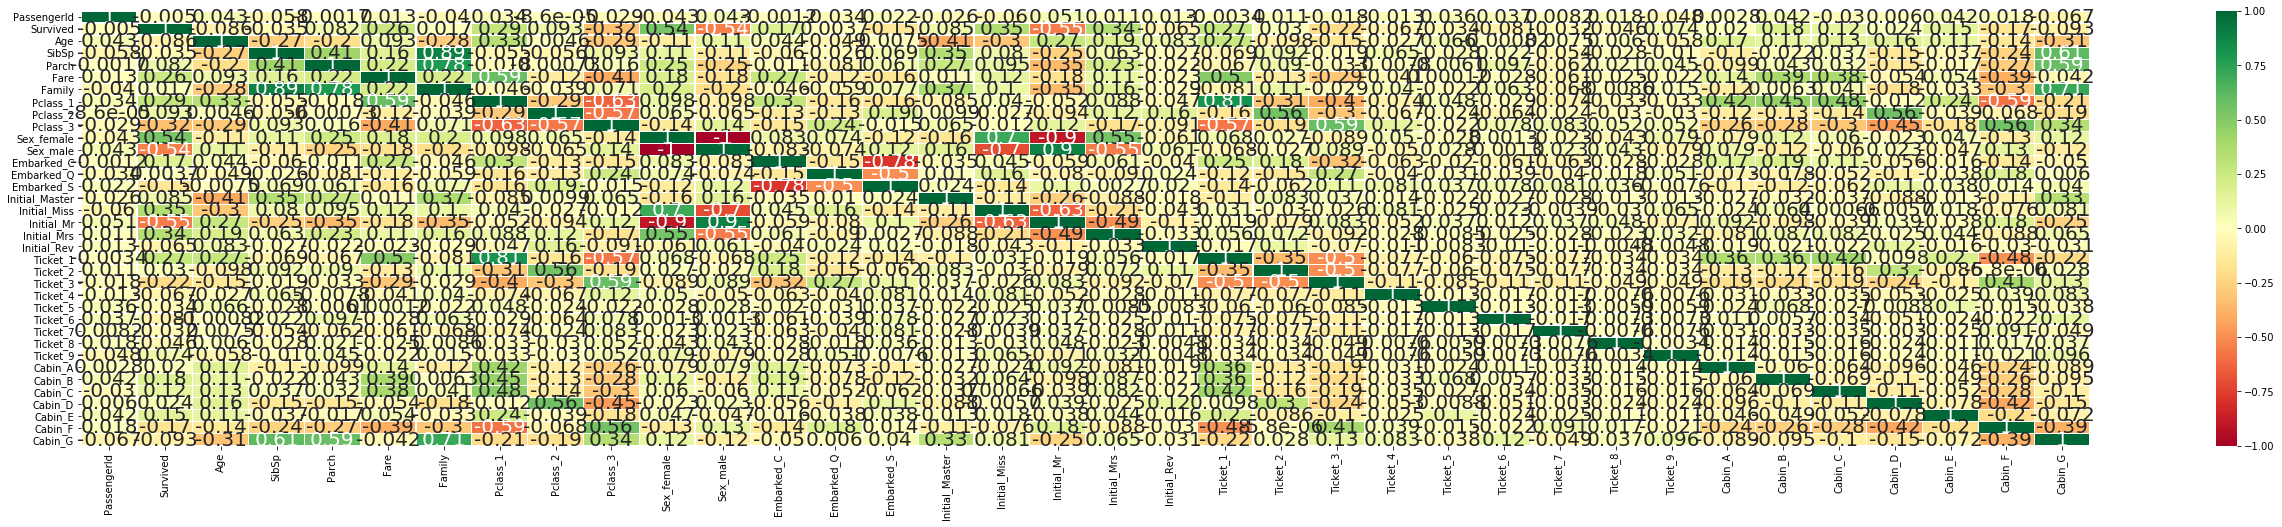

In [56]:
plt.figure(figsize=(30, 8))
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

# 3. 모델 학습

In [57]:
# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

## 데이터 준비

In [63]:
cols = ['PassengerId'
        #, 'Survived'
        , 'Age', 'SibSp', 'Parch', 'Fare', 'Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Initial_Master',
       'Initial_Miss', 'Initial_Mr', 'Initial_Mrs', 'Initial_Rev', 'Ticket_1',
       'Ticket_2', 'Ticket_3', 'Ticket_4', 'Ticket_5', 'Ticket_6', 'Ticket_7',
       'Ticket_8', 'Ticket_9', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(train[cols], train['Survived'], test_size=0.2, random_state=42)

## 하이퍼파라미터 튜닝

## 모델 훈련

In [65]:
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
svc = SVC(probability=True)
ext = ExtraTreesClassifier(random_state=1)
ada = AdaBoostClassifier(random_state=1)
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier(random_state=1)

# 리스트 준비
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier']
scores2 = {}

# 학습 및 교차 검증
for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    scores2[model_names[ind]] = acc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=1, verbose=0,
                     warm_start=False)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

GaussianNB(priors=None, var_smoothing=1e-09)

GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

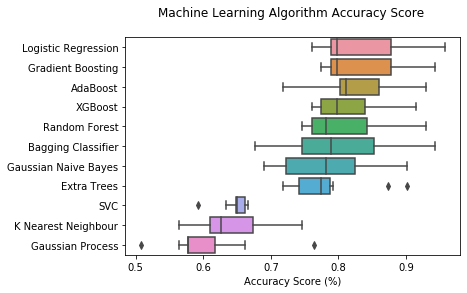

In [66]:
# 결과 테이블을 만듭니다.
results = pd.DataFrame(scores2).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)#.reset_index()
result_df.head(11)
result_df = result_df.drop(['mean'], axis=1)
sns.boxplot(data=result_df.T, orient='h')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)');

In [67]:
log.fit(train[cols], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# 4. 예측

In [68]:
predictions = log.predict(test)

# 5. 제출

In [70]:
submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
submission.to_csv("./output/20200907-1.csv", index=False)